In [7]:
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

NumPy:1.15.4
Matplotlib:3.0.2
TensorFlow:1.12.0


In [8]:
dir_path = os.path.dirname(os.path.realpath("__file__"))
DATASETSLIB_HOME = os.path.join(dir_path,'datasetslib')
print(DATASETSLIB_HOME)

import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
    
# IPython extension to reload modules before executing user code.
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%reload_ext autoreload
%autoreload 2


import datasetslib

#from datasetslib import util as dsu
import datasetslib.utils.nputil as nputil1

datasetslib.datasets_root = os.path.join(dir_path,'datasets')
print(datasetslib.datasets_root)

/notebooks/Chapter08/datasetslib
/notebooks/Chapter08/datasets


In [11]:
from datasetslib.ptb import PTBSimple
ptb = PTBSimple()
# downloads data, converts words to ids, converts files to a list of ids
ptb.load_data()
print('Train :', ptb.part['train'][0:5])
print('Test: ', ptb.part['test'][0:5])
print('Valid: ', ptb.part['valid'][0:5])
print('Vocabulary Length = ', ptb.vocab_len)

Chapter08/datasetslib/util.py
source_files:
['simple-examples.tgz']
dest_files:
['simple-examples.tgz']
Already exists: ./datasets/ptb-simple/simple-examples.tgz
Train : [9970 9971 9972 9974 9975]
Test:  [102  14  24  32 752]
Valid:  [1132   93  358    5  329]
Vocabulary Length =  10000


In [4]:
ptb.skip_window = 2
ptb.reset_index()
# in CBOW input is the context word and output is the target word
y_batch, x_batch = ptb.next_batch_cbow()

print('The CBOW pairs : context,target')
for i in range(5 * ptb.skip_window):
    print('(', [ptb.id2word[x_i] for x_i in x_batch[i]],
          ',', y_batch[i], ptb.id2word[y_batch[i]], ')')

The CBOW pairs : context,target
( ['aer', 'banknote', 'calloway', 'centrust'] , 9972 berlitz )
( ['banknote', 'berlitz', 'centrust', 'cluett'] , 9974 calloway )
( ['berlitz', 'calloway', 'cluett', 'fromstein'] , 9975 centrust )
( ['calloway', 'centrust', 'fromstein', 'gitano'] , 9976 cluett )
( ['centrust', 'cluett', 'gitano', 'guterman'] , 9980 fromstein )
( ['cluett', 'fromstein', 'guterman', 'hydro-quebec'] , 9981 gitano )
( ['fromstein', 'gitano', 'hydro-quebec', 'ipo'] , 9982 guterman )
( ['gitano', 'guterman', 'ipo', 'kia'] , 9983 hydro-quebec )
( ['guterman', 'hydro-quebec', 'kia', 'memotec'] , 9984 ipo )
( ['hydro-quebec', 'ipo', 'memotec', 'mlx'] , 9986 kia )


In [5]:
ptb.skip_window = 2
ptb.reset_index()
# in skip-gram input is the target word and output is the context word
x_batch, y_batch = ptb.next_batch_sg()

print('The skip-gram pairs : target,context')
for i in range(5 * ptb.skip_window):
    print('(', x_batch[i], ptb.id2word[x_batch[i]],
          ',', y_batch[i], ptb.id2word[y_batch[i]], ')')

The skip-gram pairs : target,context
( 9972 berlitz , 9970 aer )
( 9972 berlitz , 9971 banknote )
( 9972 berlitz , 9974 calloway )
( 9972 berlitz , 9975 centrust )
( 9974 calloway , 9971 banknote )
( 9974 calloway , 9972 berlitz )
( 9974 calloway , 9975 centrust )
( 9974 calloway , 9976 cluett )
( 9975 centrust , 9972 berlitz )
( 9975 centrust , 9974 calloway )


In [6]:
valid_size = 8
x_valid = np.random.choice(valid_size * 10, valid_size, replace=False)
print('valid: ',x_valid)

valid:  [64 58 59  4 69 53 31 77]


In [7]:
batch_size = 128
embedding_size = 128  
n_negative_samples = 64
ptb.skip_window=2

# clear the effects of previous sessions in the Jupyter Notebook
tf.reset_default_graph()

inputs = tf.placeholder(dtype=tf.int32, shape=[batch_size])
outputs = tf.placeholder(dtype=tf.int32, shape=[batch_size,1])
inputs_valid = tf.constant(x_valid, dtype=tf.int32)

In [8]:
# define embeddings matrix with vocab_len rows and embedding_size columns
# each row represents vectore representation or embedding of a word
# in the vocbulary

embed_dist = tf.random_uniform(shape=[ptb.vocab_len, embedding_size],
                               minval=-1.0,
                               maxval=1.0
                               )
embed_matrix = tf.Variable(embed_dist,
                           name='embed_matrix'
                           )
# define the embedding lookup table
# provides the embeddings of the word ids in the input tensor
embed_ltable = tf.nn.embedding_lookup(embed_matrix, inputs)

In [9]:
# define noise-contrastive estimation (NCE) loss layer

nce_dist = tf.truncated_normal(shape=[ptb.vocab_len, embedding_size],
                               stddev=1.0 /
                               tf.sqrt(embedding_size * 1.0)
                               )
nce_w = tf.Variable(nce_dist)
nce_b = tf.Variable(tf.zeros(shape=[ptb.vocab_len]))

loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_w,
                                     biases=nce_b,
                                     inputs=embed_ltable,
                                     labels=outputs,
                                     num_sampled=n_negative_samples,
                                     num_classes=ptb.vocab_len
                                     )
                      )

In [10]:
# Compute the cosine similarity between validation set samples
# and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embed_matrix), 1, 
                             keep_dims=True))
normalized_embeddings = embed_matrix / norm
embed_valid = tf.nn.embedding_lookup(normalized_embeddings, 
                                     inputs_valid)
similarity = tf.matmul(
    embed_valid, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
n_epochs = 1
learning_rate = 0.9
n_batches = ptb.n_batches_wv()
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        epoch_loss = 0
        ptb.reset_index()
        for step in range(n_batches):
            x_batch, y_batch = ptb.next_batch_sg()
            y_batch = nputil1.to2d(y_batch, unit_axis=1)
            feed_dict = {inputs: x_batch, outputs: y_batch}
            _, batch_loss = tfs.run([optimizer, loss], feed_dict=feed_dict)
            epoch_loss += batch_loss
        epoch_loss = epoch_loss / n_batches
        print('\nAverage loss after epoch ', epoch, ': ', epoch_loss)

        # print closest words to validation set at end of every epoch
        similarity_scores = tfs.run(similarity)
        top_k = 5
        for i in range(valid_size):
            similar_words = (-similarity_scores[i, :]
                             ).argsort()[1:top_k + 1]
            similar_str = 'Similar to {0:}:'.format(
                ptb.id2word[x_valid[i]])
            for k in range(top_k):
                similar_str = '{0:} {1:},'.format(
                    similar_str, ptb.id2word[similar_words[k]])
            print(similar_str)
    final_embeddings = tfs.run(normalized_embeddings)


Average loss after epoch  0 :  115.29935595928094
Similar to we: its, had, chief, l., company,
Similar to been: year, which, steel, it, low,
Similar to also: the, here, recent, research, billion,
Similar to of: compared, from, about, trade, <eos>,
Similar to last: paid, miles, be, made, sets,
Similar to u.s.: world, factory, down, inventories, <unk>,
Similar to an: one, two, under, managers, construction,
Similar to trading: countries, ii, rates, led, house,


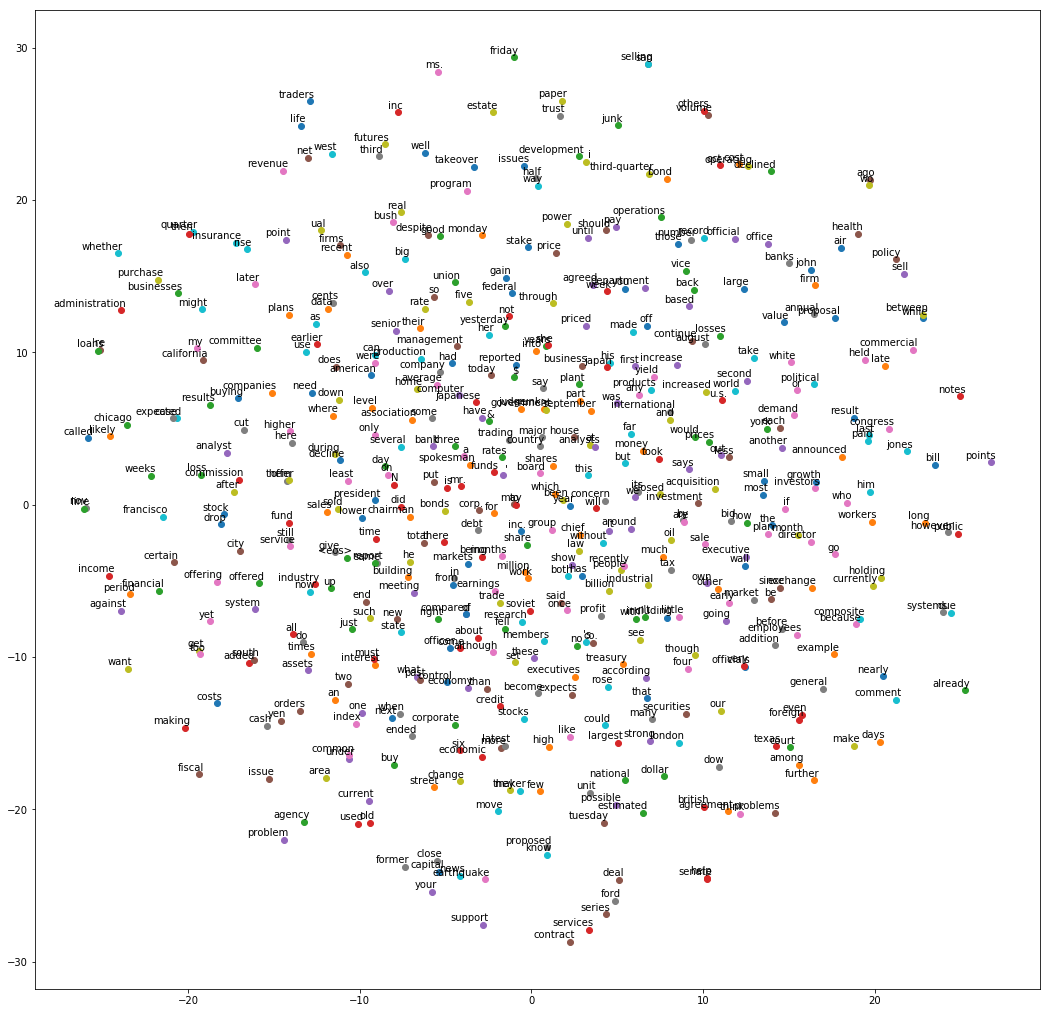

In [12]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(
        labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2,
            init='pca', n_iter=5000, method='exact')
n_embeddings = 500
low_dim_embeddings = tsne.fit_transform(final_embeddings[:n_embeddings, :])
labels = [ptb.id2word[i] for i in range(n_embeddings)]

plot_with_labels(low_dim_embeddings, labels)

In [13]:
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Reshape, Dot, merge
import keras

Using TensorFlow backend.


In [14]:
# reset the jupyter buffers
tf.reset_default_graph()
keras.backend.clear_session()

In [15]:
valid_size = 8
x_valid = np.random.choice(valid_size * 10, valid_size, replace=False)
print('valid: ',x_valid)

valid:  [20 49 77  5 19  7 10 75]


In [16]:
embedding_size = 128  
n_negative_samples = 64
ptb.skip_window=2

In [17]:
sample_table = sequence.make_sampling_table(ptb.vocab_len)
pairs, labels= sequence.skipgrams(ptb.part['train'],
                        ptb.vocab_len,
                        window_size=ptb.skip_window,
                        sampling_table=sample_table)

In [18]:
print('The skip-gram pairs : target,context')
for i in range(5 * ptb.skip_window):
    print(['{} {}'.format(id,ptb.id2word[id]) for id in pairs[i]],':',labels[i])

The skip-gram pairs : target,context
['1855 judges', '215 each'] : 1
['86 only', '686 #'] : 1
["32 n't", '273 public'] : 1
['3 N', '3975 grounds'] : 0
['3485 hire', '127 them'] : 1
['8291 peanuts', '7203 unauthorized'] : 0
['5598 belgium', '3871 promotions'] : 0
['3803 charity', '1149 newspaper'] : 0
['1710 jack', '9560 watts'] : 0
['4971 procedure', '1478 particular'] : 1


In [19]:
x,y=zip(*pairs)
x=np.array(x,dtype=np.int32)
x=nputil1.to2d(x,unit_axis=1)
y=np.array(y,dtype=np.int32)
y=nputil1.to2d(y,unit_axis=1)
labels=np.array(labels,dtype=np.int32)
labels=nputil1.to2d(labels,unit_axis=1)

In [20]:
# build the target word model
target_in = Input(shape=(1,),name='target_in')
target = Embedding(ptb.vocab_len,embedding_size,input_length=1,name='target_em')(target_in)
target = Reshape((embedding_size,1),name='target_re')(target)

# build the context word model
context_in = Input((1,),name='context_in')
context = Embedding(ptb.vocab_len,embedding_size,input_length=1,name='context_em')(context_in)
context = Reshape((embedding_size,1),name='context_re')(context)

# merge the models with the dot product to check for similarity and add sigmoid layer
output = Dot(axes=1,name='output_dot')([target,context])
output = Reshape((1,),name='output_re')(output)
output = Dense(1,activation='sigmoid',name='output_sig')(output)

# create the functional model for finding word vectors
model = Model(inputs=[target_in,context_in],outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

# merge the models and create model to check for cosine similarity
similarity = Dot(axes=0,normalize=True,name='sim_dot')([target,context])
similarity_model = Model(inputs=[target_in,context_in],outputs=similarity)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_in (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
context_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
target_em (Embedding)           (None, 1, 128)       1280000     target_in[0][0]                  
__________________________________________________________________________________________________
context_em (Embedding)          (None, 1, 128)       1280000     context_in[0][0]                 
__________________________________________________________________________________________________
target_re 

In [21]:
# train the model
n_epochs = 5
batch_size = 1024
model.fit([x,y],labels,batch_size=batch_size, epochs=n_epochs)

Epoch 1/5
1098262/1098262 [==============================] - 17s 16us/step - loss: 0.4668
Epoch 2/5
1098262/1098262 [==============================] - 20s 18us/step - loss: 0.3239
Epoch 3/5
1098262/1098262 [==============================] - 17s 15us/step - loss: 0.2399
Epoch 4/5
1098262/1098262 [==============================] - 18s 17us/step - loss: 0.1256
Epoch 5/5
1098262/1098262 [==============================] - 20s 19us/step - loss: 0.0544


In [22]:
# print closest words to validation set at end of training
top_k = 5  
y_val = np.arange(ptb.vocab_len, dtype=np.int32)
y_val = nputil1.to2d(y_val,unit_axis=1)
for i in range(valid_size):
    x_val = np.full(shape=(ptb.vocab_len,1),fill_value=x_valid[i], dtype=np.int32)
    similarity_scores = similarity_model.predict([x_val,y_val])
    similarity_scores=similarity_scores.flatten()
    similar_words = (-similarity_scores).argsort()[1:top_k + 1]
    similar_str = 'Similar to {0:}:'.format(ptb.id2word[x_valid[i]])
    for k in range(top_k):
        similar_str = '{0:} {1:},'.format(similar_str, ptb.id2word[similar_words[k]])
    print(similar_str)

Similar to from: punts, nahb, rubens, ipo, memotec,
Similar to his: rubens, regatta, carnival, nahb, ddb,
Similar to trading: sim, kia, rubens, incest, regatta,
Similar to to: kia, hottest, mlx, regatta, ethical,
Similar to as: sim, swapo, ssangyong, kia, regatta,
Similar to in: swapo, regatta, rake, punts, rubens,
Similar to that: kia, memotec, punts, mlx, ssangyong,
Similar to two: memotec, isi, kia, punts, nahb,
